## Import the library

In [6]:
import torch.nn as nn
from torchvision import datasets, transforms, models
from torch.utils.data.sampler import WeightedRandomSampler
from torch.utils.data import DataLoader, random_split
from facenet_pytorch import MTCNN
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
import os
from tqdm import tqdm
import random
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import copy
import torch

## Function for Preprocess Data

1. Crop the face
2. Resize it
3. Convert Image to Tensor

In [8]:
# MTCNN model for face detection
face_model = MTCNN(select_largest=True, device='cuda')

In [9]:
class CropFace:
    def __init__(self, face_model):
        self.face_model = face_model
    
    def __call__(self, img):
        boxes, _ = self.face_model.detect(img)
        if type(boxes) == type(None):
            cropped = img
        else:
            cropped = img.crop((boxes[0][0]-5, boxes[0][1]+5, boxes[0][2]-5, boxes[0][3]+5))
        return cropped

In [10]:
transform = transforms.Compose([
    CropFace(face_model),
    transforms.Resize((100,100)),
    transforms.ToTensor()
])

## Load Data

In [60]:
train_dir = '.\\M-LFW-FER\\M-LFW-FER\\train'
val_dir = '.\\M-LFW-FER\\M-LFW-FER\\eval'

In [104]:
train_data= datasets.ImageFolder(train_dir, transform=transform)
val_data = datasets.ImageFolder(val_dir, transform=transform)

In [62]:
train_data.class_to_idx

{'negative': 0, 'neutral': 1, 'positive': 2}

The dataset consists of three classes: negative, neutral and positive.

Check number of data in each classes:

In [63]:
# In training folder
neg_data_num = len(os.listdir(train_dir+"\\negative"))
neu_data_num = len(os.listdir(train_dir+"\\neutral"))
pos_data_num = len(os.listdir(train_dir+"\\positive"))
total_num = neg_data_num + neu_data_num + pos_data_num

print("Number of images in each class for training data")
print("Negative class: " + str(neg_data_num))
print("Neutral class: " + str(neu_data_num))
print("Positive class: " + str(pos_data_num))
print("Total: " + str(total_num))

Number of images in each class for training data
Negative class: 766
Neutral class: 3346
Positive class: 5194
Total: 9306


In [105]:
# In validation folder
neg_data_num_val = len(os.listdir(val_dir+"\\negative"))
neu_data_num_val = len(os.listdir(val_dir+"\\neutral"))
pos_data_num_val = len(os.listdir(val_dir+"\\positive"))
total_num_val = neg_data_num_val + neu_data_num_val + pos_data_num_val

print("Number of images in each class for validation data")
print("Negative class: " + str(neg_data_num_val))
print("Neutral class: " + str(neu_data_num_val))
print("Positive class: " + str(pos_data_num_val))
print("Total: " + str(total_num_val))

Number of images in each class for validation data
Negative class: 95
Neutral class: 416
Positive class: 644
Total: 1155


In [106]:
# Split validation dataset into validation and test
split_num = int(len(val_data)*0.5)
val_data, test_data = random_split(val_data, (split_num+1, split_num))

#### The data in each classes is imbalanced, handle it by using WeightedRandomSampler.

Weight assigned based on this formula: total samples / (sample in class). 
The class with lower number has a higher weight

In [50]:
train_class_weights = [total_num/neg_data_num, 
                       total_num/neu_data_num, 
                       total_num/pos_data_num]
train_class_weights

[12.148825065274151, 2.781231320980275, 1.7916827108201772]

In [51]:
train_sample_weights = [0] * len(train_data)
for idx, (_, label) in enumerate(train_data.imgs):
    train_sample_weights[idx] = train_class_weights[label]

In [52]:
train_sampler = WeightedRandomSampler(train_sample_weights, 
                                      num_samples=len(train_sample_weights), 
                                      replacement=True)

### Create data loader

In [107]:
train_loader = DataLoader(train_data, batch_size=32, sampler=train_sampler)
val_loader = DataLoader(val_data, batch_size=32)
test_loader  =  DataLoader(test_data, batch_size=1)

In [108]:
print("Number of batches in train_loader: " + str(len(train_loader)))
print("Number of batches in val_loader: " + str(len(val_loader)))
print("Number of batches in test_loader: " + str(len(test_loader)))

Number of batches in train_loader: 291
Number of batches in val_loader: 19
Number of batches in test_loader: 577


## Visualize Data

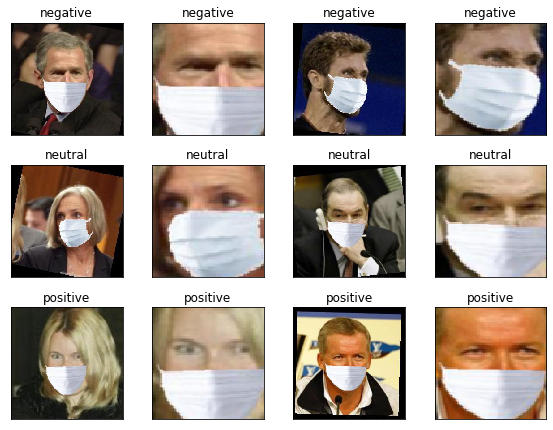

In [109]:
# remove tensor in this temp transform
temp_transform = transforms.Compose([
    CropFace(face_model),
    transforms.Resize((80,80))
])

# Image in original folder vs after transform
fig = plt.figure(1, (8,8))

idx = 0
for i in train_data.class_to_idx:
    temp_dir = train_dir+"\\"+i
    selected = random.choices(os.listdir(temp_dir), k=2)
       
    for img in selected:
        idx += 1
        ax = plt.subplot(4,4,idx)
        pil_image = Image.open(temp_dir + "\\" + img)
        img_array = np.asarray(pil_image)
        t_img_array = np.asarray(temp_transform(pil_image))
        ax.imshow(img_array)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(i)
        plt.tight_layout()
        idx+=1
        ax = plt.subplot(4,4,idx)
        ax.imshow(t_img_array)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(i)
        plt.tight_layout()

## Pretrained model

A pretrained model: MobileNetV3_small is used.

In [110]:
# Connect to cuda
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [111]:
# Initialise the model
model = models.mobilenet_v3_small(pretrained=True)

In [112]:
# Change the last layer in the sequential layer
num_features = model.classifier[-1].in_features
num_classes = 3
model.classifier[-1] = nn.Linear(num_features, 3)

In [113]:
# set up loss function, optimizer and learning rate scheduler
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

In [114]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=15):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    class_names = train_data.classes

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train().to(device)  # Set model to training mode
                dataloader = train_loader
                dataset_sizes = len(train_data)
            else:
                model.eval().to(device)   # Set model to evaluate mode
                dataloader = val_loader
                dataset_sizes = len(val_data)

            running_loss = 0.0
            running_corrects = 0
            class_correct = [0]*len(class_names)
            class_total = [0]*len(class_names)


            # Iterate over data.
            for inputs, labels in dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs).to(device)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                c = (preds == labels)
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(c)
                for i in range(len(labels)):
                    label = labels[i]
                    class_correct[label] += c[i].item()
                    class_total[label] += 1
            
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes
            epoch_acc = running_corrects.double() / dataset_sizes

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            if phase == 'val':
                for i in range(len(class_names)):
                    print(f'Accuracy of {class_names[i]} : {round(class_correct[i]/class_total[i], 4)}')
            
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [115]:
trained_model = train_model(model, criterion, optimizer, step_lr_scheduler)

Epoch 0/14
----------
train Loss: 0.8555 Acc: 0.6019
val Loss: 1.0075 Acc: 0.5623
Accuracy of negative : 0.6
Accuracy of neutral : 0.3674
Accuracy of positive : 0.6873

Epoch 1/14
----------
train Loss: 0.6183 Acc: 0.7393
val Loss: 1.2563 Acc: 0.4429
Accuracy of negative : 0.8
Accuracy of neutral : 0.6186
Accuracy of positive : 0.2817

Epoch 2/14
----------
train Loss: 0.4907 Acc: 0.7945
val Loss: 1.5419 Acc: 0.3720
Accuracy of negative : 0.825
Accuracy of neutral : 0.4512
Accuracy of positive : 0.2632

Epoch 3/14
----------
train Loss: 0.4175 Acc: 0.8256
val Loss: 1.2948 Acc: 0.5035
Accuracy of negative : 0.525
Accuracy of neutral : 0.8233
Accuracy of positive : 0.2879

Epoch 4/14
----------
train Loss: 0.3559 Acc: 0.8571
val Loss: 1.0156 Acc: 0.5571
Accuracy of negative : 0.4
Accuracy of neutral : 0.8
Accuracy of positive : 0.4149

Epoch 5/14
----------
train Loss: 0.3123 Acc: 0.8735
val Loss: 1.0417 Acc: 0.6609
Accuracy of negative : 0.375
Accuracy of neutral : 0.2977
Accuracy of po

## Accuracy on test data

In [122]:
def test():
    trained_model.eval().to(device)
    acc_counter = 0
    loss_counter = 0
    batch_counter = 0
    counter = 0
    class_names = train_data.classes
    class_correct = [0 for i in range(len(class_names))]
    class_total = [0 for i in range(len(class_names))]
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs).to(device)

            loss = criterion(outputs, labels).to(device)

            preds = torch.argmax(outputs, 1)
            acc = (preds == labels).sum().item()
            c = (preds == labels)

            for i in range(len(labels)):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1

            acc_counter += acc
            loss_counter += loss.item()
            batch_counter += len(labels)
            counter += 1

    print(f'Accuracy: {round(acc_counter/batch_counter, 4)} \t Loss: {round(loss_counter/counter, 4)}')
    for i in range(len(class_names)):
        print(f'Accuracy of {class_names[i]} : {round(class_correct[i]/class_total[i], 4)}')

In [123]:
test()

Accuracy: 0.6308 	 Loss: 1.1968
Accuracy of negative : 0.3273
Accuracy of neutral : 0.4627
Accuracy of positive : 0.7882


## Export model

In [116]:
torch.save(trained_model.state_dict(), "mobile_model2.pth")

## Using this model to predict my facial expression with face mask

In [ ]:
# Image in original folder vs after transform
fig = plt.figure(1, (4,4))
       
ax = plt.subplot(2,2,1)
test_image = Image.open('<<image_to_test>>')
img_array = np.asarray(test_image)
t_img_array = np.asarray(temp_transform(test_image))
ax.imshow(img_array)
ax.set_xticks([])
ax.set_yticks([])
ax.set_title("test image")
plt.tight_layout()
ax = plt.subplot(2,2,2)
ax.imshow(t_img_array)
ax.set_xticks([])
ax.set_yticks([])
ax.set_title("crop image")
plt.tight_layout()

In [140]:
idx_to_class = {v: k for v, k in enumerate(train_data.class_to_idx)}

In [145]:
trained_model.eval()
with torch.no_grad():
    pred = trained_model(transform(test_img).unsqueeze_(0).cuda()).detach().cpu().clone().numpy()
predicted_class = np.argmax(pred)
print("Predicted facial expression of test image: " + idx_to_class[predicted_class])

Predicted facial expression of test image: positive
